# Homework 2
## Nick Boddy<br>nboddy

Here I implement a decision tree "from scratch", using libraries only for convenience of data structuring and manipulation.

This implementation assumes that the data consists of continuous numeric features and a classification label in {0, 1}.
The tree makes splits using GainRatio. If it is determined that a leaf node contains no majority class, it defaults to "1".


Below the implementation I address questions.

## 1.    A Simplified Decision Tree

In [48]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
%matplotlib inline

df = pd.read_csv('./data/D1.txt', sep='\s+', names=['x1', 'x2', 'y'])
df.head()

,x1,x2,y
0,0.264185,0.178456,0
1,0.409499,0.213456,1
2,0.926224,0.540329,1
3,0.573685,0.282145,1
4,0.953159,0.608121,1


In [61]:
def determine_candidate_numeric_splits(D: pd.DataFrame, X: str) -> list((str, float)):
    C = []
    instances = D.sort_values(by=X)
    instances = instances.reset_index(drop=True)
    for i, row in instances.iterrows():
        if i < len(instances) - 1:
            y_i = row['y']
            y_next = instances.at[i + 1, 'y']
            x_next = instances.at[i + 1, X]
            if y_i != y_next and (X, x_next) not in C:
                C.append((X, x_next))
    return C

In [11]:
def determine_candidate_splits(D: pd.DataFrame) -> list((str, float)):
    C = []
    for feature in D.columns[:-1]:
        instances = D[:]
        C.extend(determine_candidate_numeric_splits(instances, feature))
    return C

In [26]:
def entropy_Y(D: pd.DataFrame, Y: str) -> float:
    # H(Y) = -Sum(P(y)*log2(P(y)) for each y in Y)
    H = 0
    y = D[Y].unique()
    for y_i in y:
        Py_i = sum(D[Y] == y_i) / len(D[Y])
        H += Py_i if Py_i == 0 else Py_i * math.log2(Py_i)
    H *= -1
    return H

def entropy_S(D: pd.DataFrame, S: (str, float)) -> float:
    # H(S) = -(P(X < c)*log2(P(X < c) + P(X >= c)*log2(P(X >= c)))
    # careful not to calculate log2(0)
    H = 0
    X, c = S
    Pgreater = sum(D[X] >= c) / len(D[X])
    H += Pgreater if Pgreater == 0 else Pgreater * math.log2(Pgreater)
    Plesser = sum(D[X] < c) / len(D[X])
    H += Plesser if Plesser == 0 else Plesser * math.log2(Plesser)
    H *= -1
    return H

def conditional_entropy(D: pd.DataFrame, Y: str, S: (str, float)) -> float:
    # H(Y | S) = (P(X >= c) * H(Y | X >= c)) + (P(X < c) * H(Y | X < c))
    H = 0
    X, c = S
    HYgreater = entropy_Y(D[D[X] >= c], Y)
    Pgreater = sum(D[X] >= c) / len(D[X])
    HYlesser = entropy_Y(D[D[X] < c], Y)
    Plesser = sum(D[X] < c) / len(D[X])
    H += Pgreater * HYgreater
    H += Plesser * HYlesser
    return H

In [91]:
@dataclass
class Node:
    feature: str = None
    threshold: float = None
    children: List['Node'] = None
    class_label: float = None
    layer: int = 0

    def __str__(self):
        result = ''
        if self.class_label != None:
            result += 'y = ' + str(self.class_label)
        elif self.feature and self.threshold:
            result += self.feature + ' >= ' + str(self.threshold)
        if self.children:
            result += '\n' + '\t'*self.layer + '|\n' + '\t'*self.layer + '├──' + str(self.children[0])
            result += '\n' + '\t'*self.layer + '|\n' + '\t'*self.layer + '└──' + str(self.children[1])
            #result += '[' + str(self.children[0]) + ', ' + str(self.children[1]) + ']'
        return result if result else '<???>'

In [88]:
def make_subtree(D: pd.DataFrame, layer: int = 0) -> Node:
    # print('BEGIN make_subtree')
    # print('Data: \n')
    # print(D)
    stop = False
    best_split = None
    candidate_splits = determine_candidate_splits(D[:])
    # print('Candidate splits: \n')
    # print(candidate_splits)

    # STOP if node is empty (or we have no splits)
    if len(D) == 0 or len(candidate_splits) == 0:
        stop = True
    else:
        gainRatios = []
        for split in candidate_splits:
            split_entropy = entropy_S(D, split)
            if split_entropy == 0:
                # found split with zero entropy (100% of the training instances are on one side)
                # ignore this, so set gainRatio to zero
                gainRatio = 0.0
                gainRatios.append(gainRatio)
            else:
                # GainRatio(D, Split) = (H(Y) - H(Y | Split)) / H(Split)
                gainRatio = (entropy_Y(D, 'y') - conditional_entropy(D, 'y', split)) / entropy_S(D, split)
                gainRatios.append(gainRatio)
        gainRatios = pd.Series(gainRatios)
        # STOP if all splits give 0 info (gainRatio)
        if len(gainRatios) == 0 or gainRatios.max() == 0:
            stop = True
        else:
            best_split = candidate_splits[gainRatios.idxmax()]
    if stop:
        # stopping criteria met
        # stop when there are no training instances, or 
        majority_class = D['y'].mode()
        if len(majority_class) > 1:
            majority_class = '1'
        else:
            majority_class = majority_class[0]
        # print(str(sum(D['y'] == majority_class)) + ' / ' + str(len(D)) + ' = ' + str(majority_class))
        new_node = Node(class_label=majority_class, layer=layer)
        return new_node
    else:
        # make internal node and make children subtrees
        feature, threshold = best_split
        left_data = D[D[feature] >= threshold]
        right_data = D[D[feature] < threshold]
        # print('split: ' + str(len(left_data)) + ' & ' + str(len(right_data)))
        left_child = make_subtree(left_data, layer + 1)
        right_child = make_subtree(right_data, layer + 1)
        new_node = Node(feature, threshold, [left_child, right_child], layer=layer)
        return new_node

## 2.    Questions

1. If a node is not empty but contains training items with the same label, why is it guaranteed to become a leaf? Explain. You may assume that the feature values of these items are not all the same.

If a node contains only training items of one label, say "1", it will always become a leaf because the algorithm will not produce any candidate splits (since when comparing every pair of adjacent feature values, they don't differ in label class).

Even in the case where my implementation differed and created candidate splits at every feature point, every candidate split would have either zero gain ratio or zero entropy, which triggers our stopping criteria.


2. Handcraft a small training set where both classes are present but the algorithm refuses to split; instead it makes the root a leaf and stop; Importantly, if we were to manually force a split, the algorithm will happily continue splitting the data set further and produce a deeper tree with zero training error. You should (1) plot your training set, (2) explain why. Hint: you don’t need more than a handful of items.

In [39]:
q2_df = pd.DataFrame([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 0]])
q2_df.columns = ['x1', 'x2', 'y']
q2_df

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [74]:
q2_dtree = make_subtree(q2_df)
print(q2_dtree)

0 / 4 = 1
y = 1


As we observe above, the decision tree made on the 4-row training data (q2_df), the tree consists of just a root node with class label y = 1.

This dataset doesn't allow the tree to split because it's designed in such a way that a split on any feature keeps P(y=0) equal to P(y=1). The dataset follows y:= x1 xor x2.

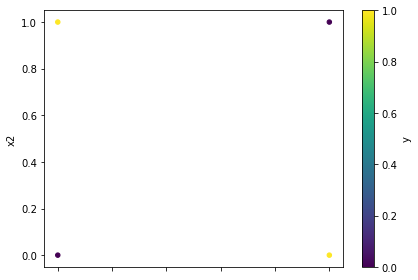

In [53]:
ax = q2_df.plot.scatter(x='x1', y='x2', c='y', colormap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
plt.show()

Above is the plot of q2_df. Yellow indicates the point has classification label 1, and purple 0.

3. Use the training set Druns.txt. For the root node, list all candidate cuts and their information gain ratio. If the entropy of the candidate split is zero, please list its mutual information (i.e. information gain). Hint: to get log2(x) when your programming language may be using a different base, use log(x)/log(2). Also, please follow the split rule in the first section.

In [54]:
druns_df = pd.read_csv('./data/Druns.txt', sep='\s+', names=['x1', 'x2', 'y'])
druns_df

,x1,x2,y
0,0.1,-2,0
1,0.0,-1,1
2,0.0,0,0
3,0.0,1,0
4,0.0,2,0
5,0.0,3,0
6,0.0,4,0
7,0.0,5,0
8,0.0,6,1
9,0.0,7,0


In [65]:
druns_root_splits = determine_candidate_splits(druns_df)
ratios = []
print('Root candidate cuts: ')
for split in druns_root_splits:
    HS = entropy_S(druns_df, split)
    HY = entropy_Y(druns_df, 'y')
    HYS = conditional_entropy(druns_df, 'y', split)
    if HS == 0:
        infoGain = HY - HYS
        print('[' + split[0] + ' >= ' + str(split[1]) + ']: ' + str(infoGain) + ' (zero split entropy)')
    else:
        gainRatio = (HY - HYS) / HS
        print('[' + split[0] + ' >= ' + str(split[1]) + ']: ' + str(gainRatio))

Root candidate cuts: 
[x1 >= 0.0]: 0.0 (zero split entropy)
[x1 >= 0.1]: 0.10051807676021852
[x2 >= -1]: 0.10051807676021852
[x2 >= 0]: 0.055953759631263686
[x2 >= 6]: 0.2360996061436081
[x2 >= 7]: 0.055953759631263686
[x2 >= 8]: 0.43015691613098095


4. Decision tree is not the most accurate classifier in general. However, it persists. This is largely due to its rumored interpretability: a data scientist can easily explain a tree to a non-data scientist. Build a tree from D3leaves.txt. Then manually convert your tree to a set of logic rules. Show the tree and the rules.

In [69]:
d3_df = pd.read_csv('./data/D3leaves.txt', sep='\s+', names=['x1', 'x2', 'y'])
d3_df

,x1,x2,y
0,10,1,1
1,10,2,1
2,10,3,1
3,1,1,0
4,1,3,1


In [92]:
d3_dtree = make_subtree(d3_df)
print(d3_dtree)

x2 >= 2
|
├──y = 1
|
└──x1 >= 10
	|
	├──y = 1
	|
	└──y = 0


The decision tree created above can also be illustrated as:
```
           ┌─true───┤y = 1
           │
x2 >= 2 ───┤                     ┌─true───┤y = 1
           │                     │
           └─false──┤x1 >= 10├───┤
                                 │
                                 └─false──┤y = 0
```
This represents the following logical expression:
```
    y = 1 if x2 >= 2 or x1 >= 10
    y = 0 otherwise
```

5. For this question only, make sure you DO NOT VISUALIZE the data sets or plot your tree’s decision boundary in the 2D x space. If your code does that, turn it off before proceeding. This is because you want to see your own reaction when trying to interpret a tree. You will get points no matter what your interpretation is. And we will ask you to visualize them in the next question anyway.
- Build a decision tree on D1.txt. Show it to us in any format (e.g. could be a standard binary tree with nodes and arrows, and denote the rule at each leaf node; or as simple as plaintext output where each line represents a node with appropriate line number pointers to child nodes; whatever is convenient for you). Again, do not visualize the data set or the tree in the x input space. In real tasks you will not be able to visualize the whole high dimensional input space anyway, so we don’t want you to “cheat” here.
- Look at your tree in the above format (remember, you should not visualize the 2D dataset or your tree’s decision boundary) and try to interpret the decision boundary in human understandable English.
- Build a decision tree on D2.txt. Show it to us.
- Try to interpret your D2 decision tree. Is it easy or possible to do so without visualization?

In [93]:
d1_df = pd.read_csv('./data/D1.txt', sep='\s+', names=['x1', 'x2', 'y'])
d1_dtree = make_subtree(d1_df)
print(d1_dtree)

x2 >= 0.201829
|
├──y = 1
|
└──y = 0


The decision tree built on D1.txt is above. It has a depth of 2 and appears to be fairly simple. If x2 is greater than or equal to 0.201829, we predict y to be 1.

In [94]:
d2_df = pd.read_csv('./data/D2.txt', sep='\s+', names=['x1', 'x2', 'y'])
d2_dtree = make_subtree(d2_df)
print(d2_dtree)

x1 >= 0.533076
|
├──x2 >= 0.228007
	|
	├──x2 >= 0.424906
		|
		├──y = 1
		|
		└──x1 >= 0.708127
			|
			├──y = 1
			|
			└──x2 >= 0.32625
				|
				├──x1 >= 0.595471
					|
					├──x1 >= 0.646007
						|
						├──y = 1
						|
						└──x2 >= 0.403494
							|
							├──y = 1
							|
							└──y = 0
					|
					└──y = 0
				|
				└──y = 0
	|
	└──x1 >= 0.887224
		|
		├──x2 >= 0.037708
			|
			├──x2 >= 0.082895
				|
				├──y = 1
				|
				└──x1 >= 0.960783
					|
					├──y = 1
					|
					└──y = 0
			|
			└──y = 0
		|
		└──x1 >= 0.850316
			|
			├──x2 >= 0.169053
				|
				├──y = 1
				|
				└──y = 0
			|
			└──y = 0
|
└──x2 >= 0.88635
	|
	├──x1 >= 0.041245
		|
		├──x1 >= 0.104043
			|
			├──y = 1
			|
			└──x1 >= 0.07642
				|
				├──y = 0
				|
				└──y = 1
		|
		└──y = 0
	|
	└──x2 >= 0.691474
		|
		├──x1 >= 0.254049
			|
			├──y = 1
			|
			└──x1 >= 0.191915
				|
				├──x2 >= 0.792752
					|
					├──y = 1
					|
					└──y = 0
				|
				└──x2 >= 0.864128
					|
					├──x1 >= 0.144781

6. For D1.txt and D2.txt, do the following separately:
- Produce a scatter plot of the data set.
- Visualize your decision tree's decision boundary (or decision region, or some other ways to clearly visualize how your decision tree will make decisions in the feature space).

Then discuss why the size of your decision trees on D1 and D2 differ. Relate this to the hypothesis space of our decision tree algorithm.


7. We provide a data set Dbig.txt with 10000 labeled items. Caution: Dbig.txt is sorted.
- You will randomly split Dbig.txt into a candidate training set of 8192 items and a test set (the rest). Do this by generating a random permutation, and split at 8192.
- Generate a sequence of five nested training sets D32 ⊂ D128 ⊂ D512 ⊂ D2048 ⊂ D8192 from the candidate training set. The subscript n in Dn denotes training set size. The easiest way is to take the first n items from the (same) permutation above. This sequence simulates the real world situation where you obtain more and more training data.
- For each Dn above, train a decision tree. Measure its test set error errn. Show three things in your
answer: (1) List n, number of nodes in that tree, errn. (2) Plot n vs. errn. This is known as a learning
curve (a single plot). (3) Visualize your decision trees’ decision boundary (five plots).